# Flowers Image Classification
In this notebook we process flowers images and build a classifier for 17 classes

[Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/)

## Contents
* Data understanding
* Feature extraction
* Data preprocessing
* Modeling
* Evaluation

In [3]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from pycaret import classification
import numpy as np
import pandas as pd
import cv2
import os
import h5py
import mahotas
import glob
import pickle

We can download the dataset from [this link](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz)

In [4]:
image_paths = sorted(glob.glob('jpg/*.jpg'))
image_paths = [x.replace('\\', '/') for x in image_paths]

### Data Understanding

In [5]:
len(image_paths)

1360

There are 1360 images divivded into 17 classes. So each class has 80 images

In [ ]:
image_paths[:3]

['jpg/image_0001.jpg', 'jpg/image_0002.jpg', 'jpg/image_0003.jpg']

Here we create a list of classes

In [ ]:
class_names = [
    'Buttercup', 'ColtsFoot', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'Pansy', 'Sunflower', 'Windflower',
    'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Tigerlily', 'Tulip', 'Cowslip'
]

We create 17 folders and each folder includes 80 images

In [ ]:
l = 0
i = 0
j = 80
for k in range(1, 18):
    os.makedirs('data/' + class_names[l])
    current_path = 'data/' + class_names[l] + '/'
    for index, image_path in enumerate(image_paths[i:j], start=1):
        original = image_path
        image_path = image_path.split('/')
        image_file_name = str(index) + '.jpg'
        os.rename(original, current_path + image_file_name)
    l += 1
    i += 80
    j += 80


### Feature Extraction Methods
* Image histogram
* Hu moments
* Haralick

Let's take one image from data

In [11]:
img = cv2.imread('drive/MyDrive/data/Daisy/1.jpg')

In [12]:
img.shape

(499, 635, 3)

Images have 3 BGR channels

#### Image Histogram Method

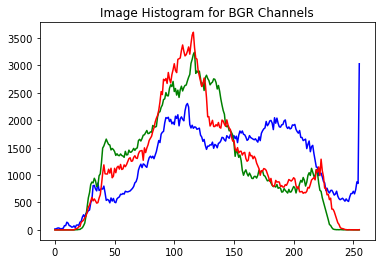

In [ ]:
for channel, col in enumerate(('b', 'g', 'r')):
        hist = cv2.calcHist([img], [channel], None, [256], [0, 256])
        plt.title('Image Histogram for BGR Channels')
        plt.plot(hist, color=col)

#### Hu Moments Method

In [13]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hue_features = cv2.HuMoments(cv2.moments(gray_img)).flatten()

In [14]:
hue_features

array([1.38546434e-03, 2.20259478e-07, 7.96571382e-12, 1.48445988e-12,
       2.32432093e-24, 4.20314992e-17, 4.54476324e-24])

7 feature extracted

#### Haralick Method

In [15]:
haralick_features = mahotas.features.haralick(gray_img)
haralick_features.mean(axis=0)

array([ 7.53021267e-04,  2.79362122e+01,  9.93432844e-01,  2.12680014e+03,
        4.19529078e-01,  2.44046016e+02,  8.47926434e+03,  8.47576958e+00,
        1.11466814e+01,  7.05985453e-04,  2.95734057e+00, -5.10389599e-01,
        9.99726600e-01])

13 features extracted

Now we apply these 3 methods to each image and crearte X and y

In [2]:
train_labels = os.listdir('drive/MyDrive/data/')
train_labels.sort()
train_labels

['Bluebell',
 'Buttercup',
 'ColtsFoot',
 'Cowslip',
 'Crocus',
 'Daffodil',
 'Daisy',
 'Dandelion',
 'Fritillary',
 'Iris',
 'LilyValley',
 'Pansy',
 'Snowdrop',
 'Sunflower',
 'Tigerlily',
 'Tulip',
 'Windflower']

In [ ]:
X = []
y = []
for label in train_labels:
    dir = os.path.join('drive/MyDrive/data', label).replace('\\', '/')
    current_label = label
    print('Current Folder: ' + current_label)
    for x in range(1, 81):
        print('Current Image: ' + str(x))
        file = os.path.join(dir, str(x) + '.jpg').replace('\\', '/')
        image = cv2.imread(file)
        image = cv2.resize(image, (500, 500))
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        histogram_features = hist.flatten()
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hue_features = cv2.HuMoments(cv2.moments(image_gray)).flatten()
        haralick_features = mahotas.features.haralick(image_gray).mean(axis=0)
        current_features = np.hstack([histogram_features, hue_features, haralick_features])
        X.append(current_features)
        y.append(current_label)

In [4]:
np.shape(X)

(1360, 532)

In [5]:
np.shape(y)

(1360,)

### Data Preprocessing
* Label Encoding
* Scaling

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
mms = MinMaxScaler()
X = mms.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


### Modeling
Here we use RandomForestClassifier

In [41]:
rfc = RandomForestClassifier(n_estimators=300, random_state=14)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=14, verbose=0, warm_start=False)

### Evaluation

In [42]:
y_pred = rfc.predict(X_test)

In [43]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56        18
           1       0.77      0.53      0.62        19
           2       0.71      0.85      0.77        26
           3       0.80      0.73      0.76        22
           4       0.58      0.65      0.61        23
           5       0.54      0.47      0.50        15
           6       0.81      0.84      0.82        25
           7       0.80      0.62      0.70        26
           8       0.90      0.39      0.55        23
           9       0.80      1.00      0.89        12
          10       0.67      0.67      0.67        24
          11       0.67      0.45      0.54        22
          12       0.71      0.94      0.81        18
          13       0.83      0.94      0.88        16
          14       0.35      0.64      0.45        11
          15       0.59      0.73      0.65        22
          16       0.75      0.83      0.79        18

    accuracy              